# Chris Working file

### Load in the Scans

In [3]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

#Constants

'''note need to remove invisible ._ files from mac: go to data folder open terminal and paste "del /s /q /f /a:h ._*" '''
#INPUT_FOLDER = '../KaggleTests/data/0a0c32c9e08cc2ea76a71649de56be6d'
INPUT_FOLDER = 'C://Users/Chris/Desktop/KaggleTests/data/0a0c32c9e08cc2ea76a71649de56be6d'

print(os.listdir('../KaggleTests'))
patients = os.listdir(INPUT_FOLDER)
patients.sort()

#load the scans into a given folder path
path = 'C://Users/Chris/Desktop/KaggleTests/data/0a0c32c9e08cc2ea76a71649de56be6d'


def load_scan(path):
    #path = self.path
    #path = path and os.path.dirname(self.path)
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../KaggleTests'

### Convert pixels

In [ ]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

### Let's take a look at one of the patients

In [ ]:
first_patient = load_scan(INPUT_FOLDER)
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

### Let's take a resampling of the data

In [13]:
def resample(image,scan, new_spacing=[1,1,1]):
    #determine the current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))
    
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing
    
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t" , first_patient_pixels.shape)
print("Shape after resampling\t" , pix_resampled.shape)



Shape before resampling	 (133, 512, 512)
Shape after resampling	 (332, 340, 340)


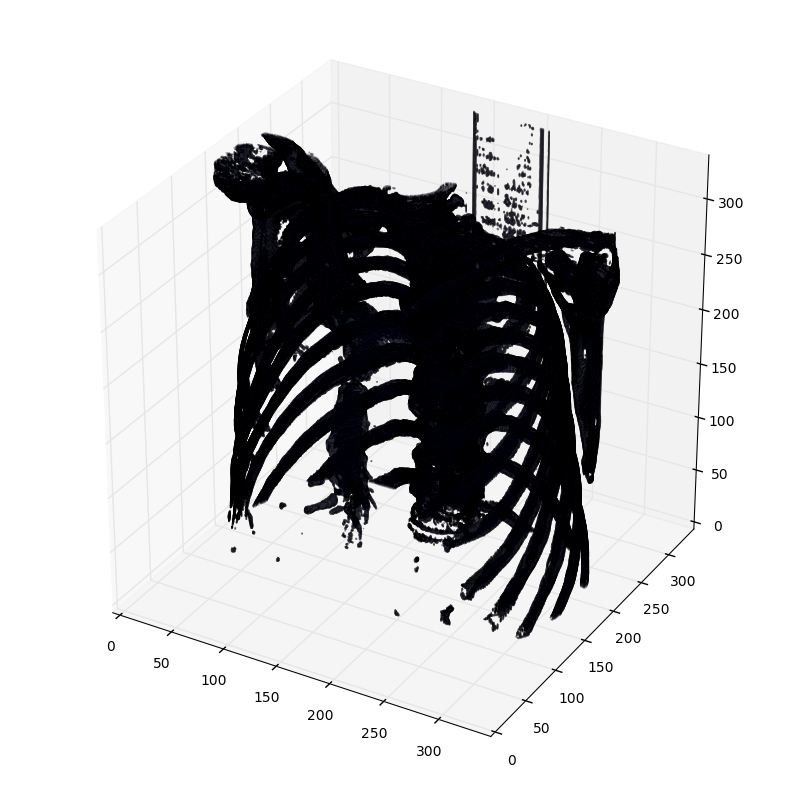

In [16]:
def plot_3d(image, threshold =-300):
    
    #postition the scan upright so that the head of the patient would be at the top factiing the camera
    p= image.transpose(2,1,0)
    p = p[:,:,::-1]

    verts, faces = measure.marching_cubes(p, threshold)
    
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection = '3d')
    
    #fancy indexing 'verts[faces]' in order to create a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha =0.1)
    face_color = [0.5 , 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    
    plt.show()

'''use the below code to run and plot a 3d mode of the rib cage @ a HU of 400'''
plot_3d(pix_resampled, 400)

### GLORIOUS!!!

## Now lets look at the lungs

In [ ]:
#lung segmentation
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    biggest = vals[np.argmax(counts)]
    return biggest

def segment_lung_mask(image , fill_lung_structures = True):
    #not truely binary as it uses 1's and 2's
    #0 is treated as background, which we want to ignore
    binary_image =  np.array(image > -320, dtype = np.int8)+1
    labels = measure.label(binary_image)
    
    #pick the pixel in the very corner which will be used to determine the label of air
    #Improvement: pick multiple background labels samples around the patient
    background_label = labels[0,0,0]

    #fill in the air around the person
    binary_image[background_label == labels] = 2

    # method of  filling the lung structures
    if fill_lung_structures:
        #for every slice we determine the largest structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg = 0)
            
            if l_max is not None: #this slice contains some lung
                binary_image[i][labeling != l_max] = 1

    binary_image -= 1 #convert the image into actural binary
    binary_image = 1- binary_image #invert the image, lungs are now 1
    
    #remove all other air pockets inside the body
    labels = measure.label(binary_image , background = 0)
    l_max = largest_label_volume(labels, bg = 0)
    if l_max is not None: # there are no air pockets
        binary_image[labels != l_max] =0

    return binary_image
    
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

plot_3d(segmented_lungs, 0)
plot_3d(segmented_lungs_fill, 0)
plot_3d(segmented_lungs_fill - segmented_lungs, 0)